In [13]:
from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [31]:
from torchvision.models import resnet50
import torchvision.transforms as transforms
import torch
from torchvision.datasets import FGVCAircraft
from utility.data.preprocessing import Autoaugment_preprocess

In [25]:
import numpy as np
import os 
from PIL import Image, ImageDraw, ImageFont

In [4]:
def reshape_transform(tensor, height=14, width=14):
    """
    Needed when using ViT
    """
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [5]:
def plot_grad_cam(model, target_class, img, dim=224, save_path=None):
    """
    img: PIL image
    """
    
    model.eval()
    
    if model.__class__.__name__ == 'ResNet':
        target_layers = [model.layer4[-1]]
    elif model.__class__.__name__ == 'EfficientNet':
        target_layers = [model.features[-2][-2]]
    elif model.__class__.__name__ == 'VisionTransformer':
        target_layers = [model.encoder.layers.encoder_layer_11.ln_1]
    elif model.__class__.__name__ == 'SwinTransformer':
        target_layers = [model.layers[-1].blocks[-1]]
    elif model.__class__.__name__ == 'Network_Wrapper':
        target_layers = [model.Features.net_layer_7[-1]]
    else:
        raise ValueError('Model not supported')
    
    if model.__class__.__name__ == 'VisionTransformer':
        cam = GradCAM(model=model, target_layers=target_layers,reshape_transform=reshape_transform)
    else:
        cam = GradCAM(model=model, target_layers=target_layers)

    transform = transforms.Compose([
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    input_tensor = transform(img)

    targets = [ClassifierOutputTarget(target_class)]

    if model.__class__.__name__ == 'Network_Wrapper':
        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]    
    else:
        grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, eigen_smooth=True)
        grayscale_cam = grayscale_cam[0, :]

    img = img.resize((dim, dim))
    img = np.float32(img) / 255

    cam_image_array = show_cam_on_image(img, grayscale_cam, use_rgb=True)

    cam_image = Image.fromarray(cam_image_array)
    
    if save_path:
        cam_image.save(save_path)
    
    return cam_image

def grad_cam_viz_with_pred(model, target_class, img, prediction, ground_truth, dim=224, save_path=None):
    cam_image = plot_grad_cam(model, target_class, img, dim=dim, save_path=None)

    draw = ImageDraw.Draw(cam_image)
    
    # Define the text to be drawn
    text = f"GT: {ground_truth}, Pred: {prediction}"
    
    # Choose a font and size (you can choose a different font if you have it)
    try:
        font = ImageFont.truetype("arial.ttf", 40)
    except IOError:
        font = ImageFont.load_default()
    
    # Define text position and color
    position = (10, 10)  # top left corner
    color = (255, 0, 0)  # red color
    
    # Draw the text on the image
    draw.text(position, text, fill=color, font=font)

    if save_path:
        cam_image.save(save_path)

    return cam_image

In [9]:
os.chdir("/home/peppe/01_Study/01_University/Semester/2/Intro_to_ML/Project/Code")

In [35]:
# change this to your data directory
data_path = "/home/peppe/01_Study/01_University/Semester/2/Intro_to_ML/Project/data"

transform = Autoaugment_preprocess(channels=3, resize_dim=(300,323), crop_dim=(224,224)) 

testset_images = FGVCAircraft(root=data_path, 
                            download=True,
                            split="test")

testset = FGVCAircraft(root=data_path, 
                     download=True,
                     split="test",
                     transform=transform.transform)

In [61]:
model = resnet50(weights="DEFAULT")

In [ ]:
grad_cam_aircraft_resnet = grad_cam_viz_with_pred(model=model,
                                                  target_class=0, 
                                                  dim=224, 
                                                  img=testset_images[10][0], 
                                                  prediction=model(testset[10][0].unsqueeze(0)).argmax().item(), 
                                                  ground_truth=testset[10][1])

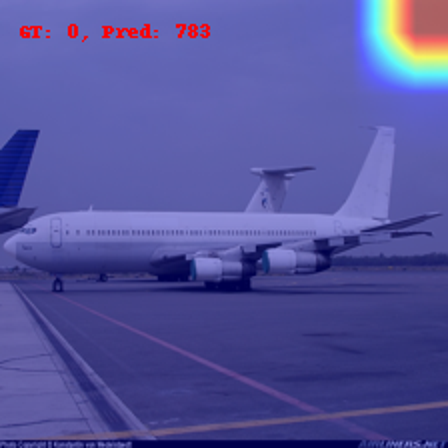

In [63]:
grad_cam_aircraft_resnet.resize((448,448))

In [ ]:
model.fc = torch.nn.Linear(2048, 100, bias=True)
checkpoint_resnet_flowers = torch.load("/home/peppe/01_Study/01_University/Semester/2/Intro_to_ML/Project/Code/experiments/Resnet50_FGVCAircraft_SAM/checkpoint.pth")
model.load_state_dict(checkpoint_resnet_flowers["model"])

In [ ]:
grad_cam_aircraft_trained_resnet = grad_cam_viz_with_pred(model=model,
                                                          target_class=0, 
                                                          dim=224, 
                                                          img=testset_images[10][0], 
                                                          prediction=model(testset[10][0].unsqueeze(0)).argmax().item(), 
                                                          ground_truth=testset[3][1])

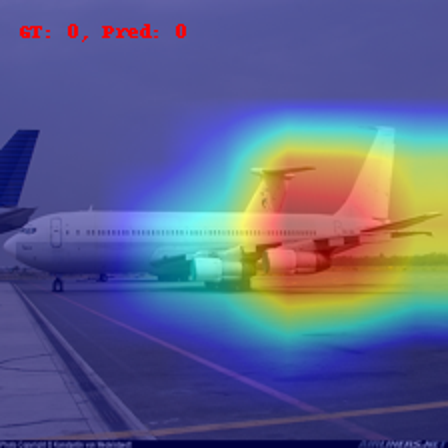

In [58]:
grad_cam_aircraft_trained_resnet.resize((448,448))